<a href="https://colab.research.google.com/github/obeabi/Stocks_TSA/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [243]:
!pip install pandas_ta


In [244]:
import logging
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Importing the Keras libraries and packages
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2.15.0


## Fetch & Load the data

In [245]:
# Fetch historical stock data using yfinance
ticker = 'VNO'
start_date , end_date = '2021-01-01' , '2024-01-30'

df = yf.download(ticker, start=start_date, end= end_date)

# Calculate technical indicators (RSI, MACD, ATR, Bolinger Bands) using pandas_ta
df.ta.rsi(close="Close", append=True)
df.ta.macd(close="Close", append=True)
df.ta.atr(length=14, append=True)
df.ta.bbands(append=True)
# Calculate the 7-day moving average
df['7_day_MA'] = df['Close'].rolling(window=7).mean()

# Fetch Federal Funds Rate data from FRED
fed_funds_rate = web.DataReader("FEDFUNDS", "fred", start_date, end_date)

# Fetch Consumer Price Index (CPI) data from FRED
cpi_data = web.DataReader("CPIAUCNS", "fred", start_date, end_date)

# Fetch VIX data from Yahoo Finance using yfinance
vix_data = yf.download("^VIX", start=start_date, end=end_date)

# Rename the 'Adj Close' column to 'VIX' for consistency
vix_data = vix_data.rename(columns={'Adj Close': 'VIX'})

# Fetch Nonfarm Payrolls data from FRED using pandas_datareader
nfp_data = web.DataReader("PAYEMS", "fred", start_date, end_date)

# Rename the column to 'Nonfarm Payrolls' for consistency
nfp_data = nfp_data.rename(columns={'PAYEMS': 'Nonfarm Payrolls'})

# Ensure both DataFrames have the same frequency (daily for stock data, monthly for NFP data)
df = df.resample('D').last()
vix_data = vix_data.resample('D').last()
cpi_data = cpi_data.resample('M').last()
nfp_data = nfp_data.resample('M').last()
fed_funds_rate = fed_funds_rate.resample('M').last()


# Merge the stock_data DataFrame with the VIX data
df = pd.merge(df, vix_data['VIX'], how='left', left_index=True, right_index=True)


# Merge the stock_data DataFrame with the Federal Funds Rate data
df = pd.merge(df, fed_funds_rate, how='left', left_index=True, right_index=True)

# Forward fill the FEDFUNDS column to fill missing daily values
df['FEDFUNDS'] = df['FEDFUNDS'].ffill()

# Merge the stock_data DataFrame with the CPI data
df = pd.merge(df, cpi_data, how='left', left_index=True, right_index=True)

# Forward fill the CPIAUCNS column to fill missing daily values
df['CPIAUCNS'] = df['CPIAUCNS'].ffill()

# Merge the stock_data DataFrame with the Nonfarm Payrolls data
df = pd.merge(df, nfp_data, how='left', left_index=True, right_index=True)

# Forward fill the Nonfarm Payrolls column to fill missing daily values
df['Nonfarm Payrolls'] = df['Nonfarm Payrolls'].ffill()

# Drop rows with missing values in the index
df = df.dropna(subset=None)

df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,VIX,FEDFUNDS,CPIAUCNS,Nonfarm Payrolls
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-22,37.450001,40.709999,37.450001,40.680000,35.587070,4216500.0,63.243048,0.246813,-0.013525,0.260338,...,34.646426,37.726000,40.805574,16.326005,0.979612,38.014286,23.450001,0.09,261.582,142969.0
2021-02-23,41.000000,43.540001,40.310001,42.849998,37.485397,4390800.0,69.570868,0.607202,0.277491,0.329711,...,33.751353,38.816000,43.880647,26.095667,0.898251,38.552857,23.110001,0.09,261.582,142969.0
2021-02-24,42.900002,44.990002,42.810001,44.599998,39.016296,2586500.0,73.528667,1.022239,0.554023,0.468217,...,33.884377,40.307999,46.731622,31.872694,0.834079,39.440000,21.340000,0.09,261.582,142969.0
2021-02-25,44.730000,45.590000,42.200001,42.689999,37.345425,2899100.0,63.778375,1.183397,0.572144,0.611253,...,36.592565,41.613999,46.635434,24.133390,0.607141,40.195714,28.889999,0.09,261.582,142969.0
2021-02-26,42.740002,43.470001,42.169998,42.939999,37.564121,2773300.0,64.443001,1.316117,0.563891,0.752226,...,40.260883,42.751999,45.243115,11.653798,0.537734,41.024285,27.950001,0.09,261.582,142969.0


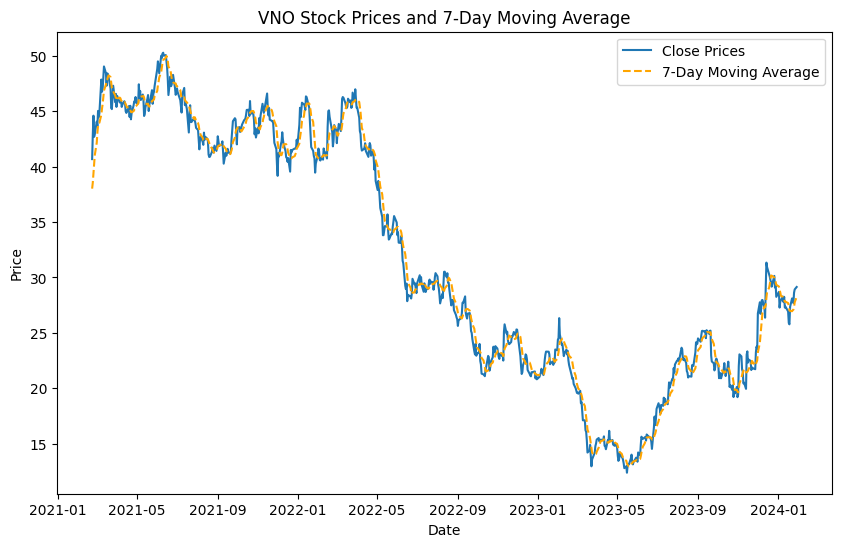

In [246]:
# Plot the closing prices and 7-day moving average
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Prices')
plt.plot(df['7_day_MA'], label='7-Day Moving Average', linestyle='--', color='orange')
plt.title(f'{ticker} Stock Prices and 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [247]:
# Assuming df is your DataFrame with a 'Date' column

# Determine the split index based on the last two days
split_index = len(df) - 10

# Split the DataFrame into training and test sets
dataset_train = df.iloc[:split_index]
dataset_test  = df.iloc[split_index:]


dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,VIX,FEDFUNDS,CPIAUCNS,Nonfarm Payrolls
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-22,37.450001,40.709999,37.450001,40.680000,35.587070,4216500.0,63.243048,0.246813,-0.013525,0.260338,...,34.646426,37.726000,40.805574,16.326005,0.979612,38.014286,23.450001,0.09,261.582,142969.0
2021-02-23,41.000000,43.540001,40.310001,42.849998,37.485397,4390800.0,69.570868,0.607202,0.277491,0.329711,...,33.751353,38.816000,43.880647,26.095667,0.898251,38.552857,23.110001,0.09,261.582,142969.0
2021-02-24,42.900002,44.990002,42.810001,44.599998,39.016296,2586500.0,73.528667,1.022239,0.554023,0.468217,...,33.884377,40.307999,46.731622,31.872694,0.834079,39.440000,21.340000,0.09,261.582,142969.0
2021-02-25,44.730000,45.590000,42.200001,42.689999,37.345425,2899100.0,63.778375,1.183397,0.572144,0.611253,...,36.592565,41.613999,46.635434,24.133390,0.607141,40.195714,28.889999,0.09,261.582,142969.0
2021-02-26,42.740002,43.470001,42.169998,42.939999,37.564121,2773300.0,64.443001,1.316117,0.563891,0.752226,...,40.260883,42.751999,45.243115,11.653798,0.537734,41.024285,27.950001,0.09,261.582,142969.0


In [248]:
# Columns on the dataframe
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ATRr_14',
       'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0',
       '7_day_MA', 'VIX', 'FEDFUNDS', 'CPIAUCNS', 'Nonfarm Payrolls'],
      dtype='object')

In [249]:
# Specify the names of the two columns
column1 = 'Open'
column2 = 'Close'

# Create a new column with the average
#dataset_train['Open'] = dataset_train[[column1, column2]].mean(axis=1)
#dataset_test['Open'] = dataset_test[[column1, column2]].mean(axis=1)

# You can use 'Open' rather than 'Price'
features = ['7_day_MA', 'Volume','VIX', 'ATRr_14']
#features = ['Open', 'Close', 'Volume']
#features = ['Open','price', 'Close', 'Volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9','MACDs_12_26_9', 'ATRr_14', 'VIX', 'FEDFUNDS', 'CPIAUCNS']

dataset_train= dataset_train[features].copy()
dataset_test= dataset_test[features].copy()
no_indicators = len(features)


# Drop rows with missing data
dataset_train.dropna(inplace= True)
# Fill missing values in columns 'A' and 'B' using backfill
#columns_to_fill = features
#dataset_train[columns_to_fill] = dataset_train[columns_to_fill].fillna(method='bfill')

# Columns to be scaled (excluding Federal Funds Rate)
#columns_to_scale = ['Open', 'Volume', 'RSI_14', 'VIX']

train_features = dataset_train.iloc[:, 0:].values


dataset_train.head()

,7_day_MA,Volume,VIX,ATRr_14
Date,,,,
2021-02-22,38.014286,4216500.0,23.450001,1.453234
2021-02-23,38.552857,4390800.0,23.110001,1.591254
2021-02-24,39.440000,2586500.0,21.340000,1.636704
2021-02-25,40.195714,2899100.0,28.889999,1.771279
2021-02-26,41.024285,2773300.0,27.950001,1.735298


### Feature Scaling

In [250]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_features)

print("The length of the sacled data is :" ,len(training_set_scaled) )
print()
training_set_scaled[0:5]

The length of the sacled data is : 729



array([[0.67667029, 0.06150734, 0.46677607, 0.6230824 ],
       [0.69121279, 0.06439492, 0.45283021, 0.7345516 ],
       [0.71516742, 0.03450355, 0.3802297 , 0.77125834],
       [0.73557321, 0.03968232, 0.68990972, 0.87994453],
       [0.7579463 , 0.03759822, 0.65135358, 0.85088508]])

### Creating a data structure with 180 timesteps and 1 output

In [251]:
day_lag = 60
X_train = []
y_train = []
for i in range(day_lag, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-day_lag:i, 0:])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping the dataset to add more indicators

In [252]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], no_indicators))

In [253]:
print("Shape of X_train after reshaping:", X_train.shape)

Shape of X_train after reshaping: (669, 60, 4)


## Part 2 - Building and Training the LSTM

### Initialising the RNN

In [254]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [255]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], no_indicators)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [256]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [257]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [258]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [259]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [260]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [261]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
21/21 [==============================] - 23s 232ms/step - loss: 0.0636
Epoch 2/100
21/21 [==============================] - 6s 268ms/step - loss: 0.0112
Epoch 3/100
21/21 [==============================] - 5s 234ms/step - loss: 0.0074
Epoch 4/100
21/21 [==============================] - 2s 115ms/step - loss: 0.0075
Epoch 5/100
21/21 [==============================] - 2s 114ms/step - loss: 0.0074
Epoch 6/100
21/21 [==============================] - 2s 116ms/step - loss: 0.0067
Epoch 7/100
21/21 [==============================] - 3s 155ms/step - loss: 0.0065
Epoch 8/100
21/21 [==============================] - 3s 125ms/step - loss: 0.0060
Epoch 9/100
21/21 [==============================] - 2s 119ms/step - loss: 0.0066
Epoch 10/100
21/21 [==============================] - 2s 116ms/step - loss: 0.0059
Epoch 11/100
21/21 [==============================] - 2s 116ms/step - loss: 0.0055
Epoch 12/100
21/21 [==============================] - 4s 170ms/step - loss: 0.0054
Epoch 13/100

## Part 3 - Making the predictions and visualising the results

In [262]:
# Drop rows with missing data
#dataset_test[columns_to_fill] = dataset_test[columns_to_fill].fillna(method='bfill')
dataset_test.head()

,7_day_MA,Volume,VIX,ATRr_14
Date,,,,
2024-01-16,27.688572,3087300.0,13.84,1.268878
2024-01-17,27.395715,2110800.0,14.79,1.300387
2024-01-18,27.037143,1852800.0,14.13,1.270359
2024-01-19,26.975715,2125700.0,13.30,1.306048
2024-01-22,26.955715,2894100.0,13.19,1.273473


In [263]:
# Plot a line chart using Plotly Express
fig = px.line(dataset_test, x=dataset_test.index, y='7_day_MA', title='Stock Price Over Time')

# Show the plot
fig.show()

In [264]:
# if Open price use this
real_stock_price = dataset_test.iloc[:, 0:1].values

# if Avergae price use this
#real_stock_price = dataset_test.iloc[:, -1:].values
real_stock_price[0:5]

array([[27.68857193],
       [27.39571462],
       [27.03714316],
       [26.97571455],
       [26.95571463]])

In [265]:
len(dataset_test)

10

### Getting the predicted stock price

In [266]:
# You can use 'Open'rather than 'Price'
dataset_total = pd.concat((dataset_train[features], dataset_test[features]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - day_lag : ].values
print("Shape of inputs before reshaping:", inputs.shape)
inputs = inputs.reshape(-1,no_indicators)
print("\nShape of inputs after reshaping:", inputs.shape)
inputs = sc.transform(inputs)

# Account for the 3D structure required by the LSTM
X_test = []
for i in range(day_lag, day_lag + len(dataset_test)):
    X_test.append(inputs[i-day_lag:i, 0:])


X_test = np.array(X_test)
print("Shape of X_test before reshaping:", X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], no_indicators))
print("\nShape of X_test after reshaping:", X_test.shape)
predicted_stock_price = regressor.predict(X_test)


# Concatenate each entry with zero individually
# Replace `x` with the desired number of zeros
num_zeros = no_indicators- 1
predicted_stock_price = np.array([np.concatenate((entry, np.zeros(num_zeros))) for entry in predicted_stock_price])



# Apply inverse_transform to concatenated_results
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Extract the first element from each entry (model predictions)
model_predictions = predicted_stock_price[:, 0]


Shape of inputs before reshaping: (70, 4)

Shape of inputs after reshaping: (70, 4)
Shape of X_test before reshaping: (10, 60, 4)

Shape of X_test after reshaping: (10, 60, 4)
1/1 [==============================] - 2s 2s/step


### Visualising the results

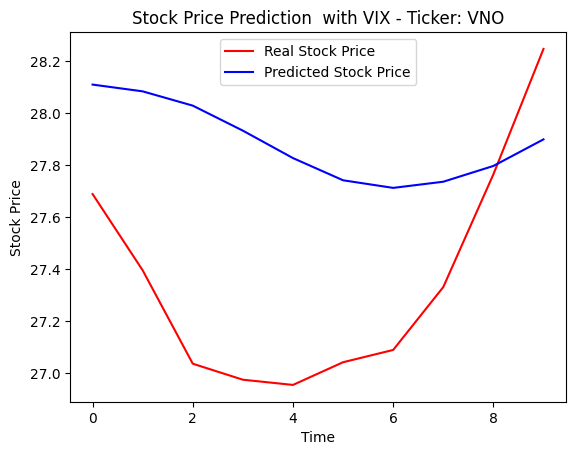

In [267]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(model_predictions , color = 'blue', label = 'Predicted Stock Price')
plt.title(f'Stock Price Prediction  with VIX - Ticker: {ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Monte- Carlo Simulation

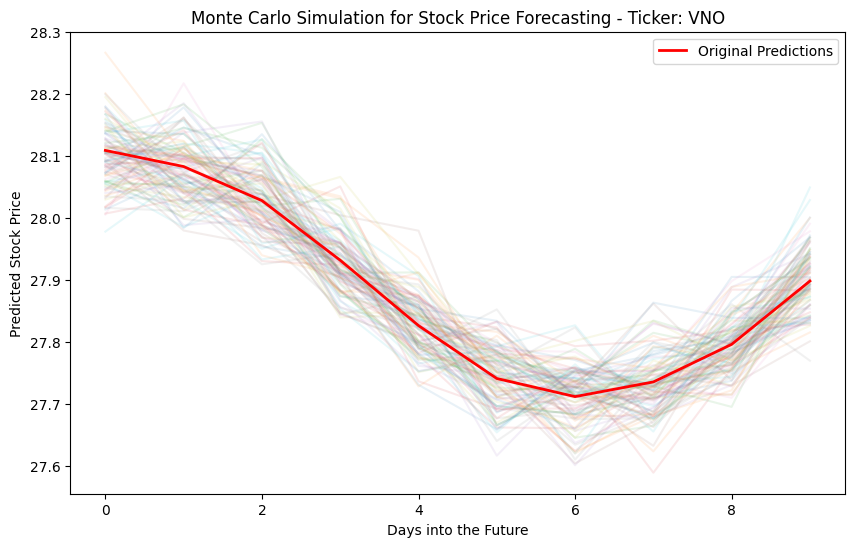

In [268]:
# Generate dummy features for the next few day

# Number of simulations for the Monte Carlo simulation
num_simulations = 100

# Create an array to store simulation results
simulation_results = np.zeros((num_simulations, len(model_predictions)))

# Perform Monte Carlo simulation
for i in range(num_simulations):
    # Introduce random noise to the model predictions
    noise = np.random.normal(0, 0.05, len(model_predictions))  # Adjust the standard deviation as needed
    simulated_predictions = model_predictions + noise

    # Store the simulated predictions in the results array
    simulation_results[i, :] = simulated_predictions

# Plot the Monte Carlo simulation results
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(np.arange(len(model_predictions)), simulation_results[i, :], linestyle='-', marker='', alpha=0.1)

# Plot the original predictions
plt.plot(np.arange(len(model_predictions)), model_predictions, label='Original Predictions', color='red', linewidth=2)

plt.title(f'Monte Carlo Simulation for Stock Price Forecasting - Ticker: {ticker}')
plt.xlabel('Days into the Future')
plt.ylabel('Predicted Stock Price')
plt.legend()
plt.show()
